## Transfomer

In [1]:
"""%%bash
python3 -m pip install --user torch
python3 -m pip install --user scikit-learn"""

'%%bash\npython3 -m pip install --user torch\npython3 -m pip install --user scikit-learn'

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

## Data定義

In [ ]:
%%time
#6分ぐらいかかる
df_aal = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_aal.csv')
df_ho = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_ho.csv')

#df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
#df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')

df_subjects_info = pd.read_csv('../02_data_analysis/subjects_info/subjects_info.csv')

In [ ]:
def make_info_data(df = df_subjects_info,col = ['Age','Sex','やる気スコア(Apathy scale)']):
    subID = np.array(df.subID)
    subjects_info_list = []
    for ID in subID:
        data = np.array(df[df.subID == ID][col])[0]
        if 'Sex' in col:
            idx = col.index('Sex')
            if data[idx] == '男':
                data[idx] = 0
            else:
                data[idx] = 1
        subjects_info_list.append(data)
    subjects_info = np.array(subjects_info_list)
    
    for i in range(len(col)):
        if i == idx:
            continue
        else:
            subjects_info[:,i] = (subjects_info[:,i] - \
                                  np.mean(subjects_info[:,i]))/np.std(subjects_info[:,i])
    return subjects_info.astype(np.float)

def make_data(df, subID = df_subjects_info.subID ,remove_list = ['time','subID']):
    data_list = []
    df_cols = list(df.columns)
    for r in remove_list:
        try:
            df_cols.remove(r)
        except:
            pass
    for ID in df_subjects_info.subID:
        data = df[df.subID == ID][df_cols]
        data = np.array(data)
        data_list.append(data)
    data = np.array(data_list)
    return data

In [ ]:
%%time
data_label = make_info_data()
data_aal = make_data(df_aal)
data_ho = make_data(df_ho)

age_mean = df_subjects_info.Age.mean()
age_std = df_subjects_info.Age.std()

data_label.shape
data_aal.shape
data_ho.shape

In [ ]:
#30秒ぐらいかかる
#data_dynamic_aal = make_data(df_dynamic_aal)
#data_dynamic_ho = make_data(df_dynamic_ho)

#data_dynamic_aal.shape
#data_dynamic_ho.shape

## Model作成

In [ ]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        # Not a parameter
        self.register_buffer('pe', self._pe_table(d_model, max_len))

    def _pe_table(self, d_model: int, max_len: int) -> torch.Tensor:
        pos = torch.arange(0, max_len).unsqueeze(1)
        pe_denominator = torch.exp(
            torch.arange(0, d_model, 2) * math.log(10000) / d_model
        )

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(pos / pe_denominator)  # 偶数項にはsin
        pe[:, 1::2] = torch.cos(pos / pe_denominator)  # 奇数項にはcos

        pe = pe.unsqueeze(0)  # バッチに対応するため
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x + self.pe[:, :x.size(1)].clone().detach())

In [ ]:
class Model(nn.Module):    
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 time_len,nhead,
                 output_dim,
                 hidden_dim_transformer,
                 fc_drop = 0.1,
                 trans_drop = 0.1):
        super(Model, self).__init__()
        self.fc0  = nn.Linear(input_dim,hidden_dim)
        self.pos  = PositionalEncoding(d_model = hidden_dim,dropout=fc_drop)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(hidden_dim,
                                                                    nhead,
                                                                    dropout=trans_drop,
                                                                    dim_feedforward=hidden_dim,
                                                                    batch_first=True)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.fc1  = nn.Linear(hidden_dim,1)
        self.fc2  = nn.Linear(time_len,1)
        self.drop  = nn.Dropout(0.1)
        self.time_len = time_len
        
    def forward(self,x):
        x = self.fc0(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        x = self.fc1(x)
        x = self.drop(x)
        x = torch.reshape(x, (-1, self.time_len))
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1))
        return x

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label=None):
        self.data = data
        self.label = label
        self.test = label is None
        self.length = data.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self,idx):
        if self.test:
            data = torch.tensor(self.data[idx])
            return data
        else:
            data = torch.tensor(self.data[idx])
            label = torch.tensor(self.label[idx])
            return data, label

In [ ]:
def train_model(data,
                label,
                epochs=1000,
                n_splits=5,
                train_size = 0.8,
                criterion = nn.MSELoss()):
    
    epochs = epochs
    seed = 0
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    label_age = np.array([label[:,0]]).T
    train_all, test, train_all_label, test_label = train_test_split(data,
                                                                    label_age,
                                                                    train_size = train_size,
                                                                    shuffle=False)
    
    test_dataset = MyDataset(test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32)
    
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=n_splits)
    test_pred_all = []
    
    for i, (train_index, val_index) in enumerate(kf.split(train_all)):
        
        early_stopping = 1e5
        save_epochs = 0
        
        train_loss_plot = []
        val_loss_plot = []
        
        train, train_label = train_all[train_index], train_all_label[train_index]
        val,   val_label   = train_all[val_index],   train_all_label[val_index]
        
        train_dataset = MyDataset(train,train_label)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

        val_dataset = MyDataset(val,val_label)
        val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=32)
        
        input_dim  = train.shape[2]
        time_len   = train.shape[1]
        output_dim = train_label.shape[1]
        hidden_dim = 128
        nhead      = 32
        hidden_dim_transformer = 2
        fc_drop = 0.1
        trans_drop = 0.1
        
        model = Model(input_dim,
                      hidden_dim,
                      time_len,
                      nhead,
                      output_dim,
                      hidden_dim_transformer,
                      fc_drop,
                      trans_drop).to(device)
        
        criterion = criterion
        optimizer = torch.optim.AdamW(model.parameters())

        def compute_loss(y, t):
            return criterion(y, t)

        def train_step(x,t):
            model.train()
            preds = model(x)
            loss = compute_loss(preds, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            return loss, preds

        def val_step(x,t):
            model.eval()
            preds = model(x)
            loss = compute_loss(preds, t)    
            return loss, preds

        def test_step(x):
            model.eval()
            preds = model(x)
            return preds
        
        for epoch in range(epochs):
            train_loss = 0.
            val_loss = 0.

            for (x, t) in train_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = train_step(x,t)
                train_loss += loss.item()
            train_loss /= len(train_dataloader)
            
            val_pred = []
            for (x, t) in val_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = val_step(x,t)
                val_loss += loss.item()
                if epochs == epoch+1:
                    val_pred.append(preds)
                
            val_loss /= len(val_dataloader)
            if (epoch+1) % 100 == 0:
                print(f'Kfold: {i+1} ::: epoch: {epoch+1}, loss: {train_loss}, val loss: {val_loss}')
            """if early_stopping >= val_loss:
                early_stopping = val_loss
                model_path = '../02_data_analysis/model/model_.pth'
                torch.save(model.state_dict(), model_path)
                save_epochs = epoch+1"""
        
            train_loss_plot.append(train_loss)
            val_loss_plot.append(val_loss)
        
        #model.load_state_dict(torch.load(model_path))
        #print(f'save_epochs:{save_epochs}')
        
        train_loss_plot = np.array(train_loss_plot)
        val_loss_plot   = np.array(val_loss_plot)
        x               = np.linspace(0, len(train_loss_plot), len(train_loss_plot))
        
        plt.figure(figsize=(6, 4), dpi=80)
        plt.plot(x, train_loss_plot, label="train loss")
        plt.plot(x, val_loss_plot, label="val loss")
        plt.legend()
        plt.grid()
        plt.show()
        
        train_pred = []
        train_label = []
        for (x, t) in train_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = train_step(x,t)
            train_pred.append(preds)
            train_label.append(t)
            
        val_pred = []
        for (x, t) in val_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = val_step(x,t)
            val_pred.append(preds)
        
        train_pred = torch.cat(train_pred)
        train_pred = train_pred.to('cpu').detach().numpy().copy()
        
        train_label = torch.cat(train_label)
        train_label = train_label.to('cpu').detach().numpy().copy()
        
        val_pred = torch.cat(val_pred)
        val_pred = val_pred.to('cpu').detach().numpy().copy()
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((train_label[:,0]*age_std)+age_mean,(np.array(train_pred[:,0])*age_std)+age_mean)
        plt.xlabel('chronological age') # x軸のラベル
        plt.ylabel('predicted age') # y軸のラベル
        #plt.legend()
        plt.grid()
        plt.show()
        print(np.corrcoef(train_label[:,0],np.array(train_pred[:,0])))
        print('r^2 train data: ', r2_score(train_label[:,0],np.array(train_pred[:,0])))
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((val_label[:,0]*age_std)+age_mean,(np.array(val_pred[:,0])*age_std)+age_mean)
        plt.xlabel('chronological age') # x軸のラベル
        plt.ylabel('predicted age') # y軸のラベル
        #plt.legend()
        plt.grid()
        plt.show()
        print(np.corrcoef(val_label[:,0],np.array(val_pred[:,0])))
        print('r^2 train data: ', r2_score(val_label[:,0],np.array(val_pred[:,0])))
        
        lr = LinearRegression()
        lr.fit(val_label*age_std+age_mean,val_pred[:,0]*age_std+age_mean)
        
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter(val_label[:,0]*age_std+age_mean,val_pred[:,0]*age_std+age_mean)#散布図をプロット
        plt.plot(val_label[:,0]*age_std + age_mean,
                 lr.predict(val_label*age_std+age_mean), color = 'red')#回帰直線をプロット
        
        plt.title('Regression Line') # 図のタイトル
        plt.xlabel('chronological age') # x軸のラベル
        plt.ylabel('predicted age') # y軸のラベル
        #plt.legend()# 説明
        plt.grid()  # グリッド線を表示
        plt.show()  # 図の表示
        print('切片:', lr.intercept_)
        print('傾き:', lr.coef_)
                
        test_pred = []
        for x in test_dataloader:
            x = x.to(device)
            x = x.float()
            preds = test_step(x)
            test_pred.append(preds)
        test_pred = torch.cat(test_pred)
        test_pred = test_pred.to('cpu').detach().numpy().copy()
        test_pred_all.append(test_pred)
    return np.array(test_pred_all),test_label

In [ ]:
%%time
# 128 32 2 0.1 0.1 128 last:fc1 drop 0.1 fc2
test_pred,test_label = train_model(data_aal,
                                   data_label,
                                   epochs=750,
                                   n_splits=5,
                                   train_size = 0.8,
                                   criterion = nn.MSELoss()
                                  )

In [ ]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[0,:,0]*age_std+age_mean)
plt.grid()
plt.show()
np.corrcoef(test_label[:,0],test_pred[0,:,0])

In [ ]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[1,:,0]*age_std+age_mean)
plt.grid()
plt.show()
np.corrcoef(test_label[:,0],test_pred[1,:,0])

In [ ]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[2,:,0]*age_std+age_mean)
plt.grid()
plt.show()
np.corrcoef(test_label[:,0],test_pred[2,:,0])

In [ ]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[3,:,0]*age_std+age_mean)
plt.grid()
plt.show()
np.corrcoef(test_label[:,0],test_pred[3,:,0])

In [ ]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[4,:,0]*age_std+age_mean)
plt.grid()
plt.show()
np.corrcoef(test_label[:,0],test_pred[4,:,0])

In [ ]:
"""plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[5,:,0]*age_std+age_mean)
plt.grid()
plt.show()
np.corrcoef(test_label[:,0],test_pred[5,:,0])"""

In [46]:
"""plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[6,:,0]*age_std+age_mean)
plt.grid()
plt.show()
np.corrcoef(test_label[:,0],test_pred[6,:,0])"""

'plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[6,:,0]*age_std+age_mean)\nplt.grid()\nplt.show()\nnp.corrcoef(test_label[:,0],test_pred[6,:,0])'

In [47]:
"""plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[7,:,0]*age_std+age_mean)
plt.grid()
plt.show()
np.corrcoef(test_label[:,0],test_pred[7,:,0])"""

'plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[7,:,0]*age_std+age_mean)\nplt.grid()\nplt.show()\nnp.corrcoef(test_label[:,0],test_pred[7,:,0])'

In [48]:
"""plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[8,:,0]*age_std+age_mean)
plt.grid()
plt.show()
np.corrcoef(test_label[:,0],test_pred[8,:,0])"""

'plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[8,:,0]*age_std+age_mean)\nplt.grid()\nplt.show()\nnp.corrcoef(test_label[:,0],test_pred[8,:,0])'

In [49]:
"""plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[9,:,0]*age_std+age_mean)
plt.grid()
plt.show()
np.corrcoef(test_label[:,0],test_pred[9,:,0])"""

'plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[9,:,0]*age_std+age_mean)\nplt.grid()\nplt.show()\nnp.corrcoef(test_label[:,0],test_pred[9,:,0])'

<Figure size 480x480 with 0 Axes>

'plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[5,:,0]*age_std+age_mean)\nplt.scatter(test_label[:,0]*age_std+age_mean,test_pred[6,:,0]*age_std+age_mean)\nplt.scatter(test_label[:,0]*age_std+age_mean,test_pred[7,:,0]*age_std+age_mean)\nplt.scatter(test_label[:,0]*age_std+age_mean,test_pred[8,:,0]*age_std+age_mean)\nplt.scatter(test_label[:,0]*age_std+age_mean,test_pred[9,:,0]*age_std+age_mean)'

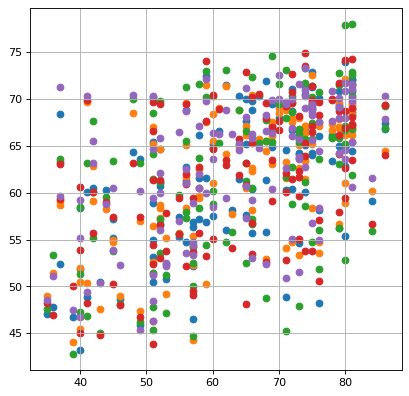

In [50]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[0,:,0]*age_std+age_mean)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[1,:,0]*age_std+age_mean)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[2,:,0]*age_std+age_mean)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[3,:,0]*age_std+age_mean)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[4,:,0]*age_std+age_mean)
"""plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[5,:,0]*age_std+age_mean)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[6,:,0]*age_std+age_mean)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[7,:,0]*age_std+age_mean)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[8,:,0]*age_std+age_mean)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[9,:,0]*age_std+age_mean)"""
plt.grid()
plt.show()

LinearRegression()

<Figure size 480x480 with 0 Axes>

Text(0.5, 1.0, 'Regression Line')

Text(0.5, 0, 'chronological age')

Text(0, 0.5, 'predicted age')

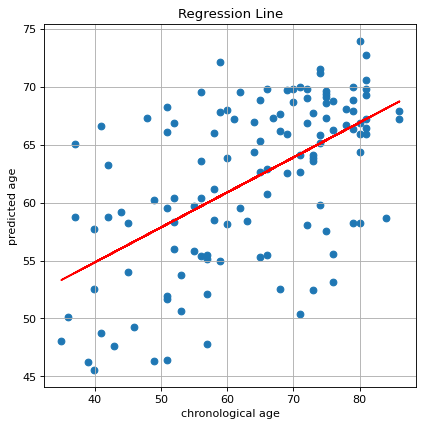

array([[1.        , 0.56646792],
       [0.56646792, 1.        ]])

r^2 train data:  0.30278364345625164
切片: 42.73002695708563
傾き: [0.30254607]


In [51]:
test_pred_mean = test_pred.mean(axis=0)
lr = LinearRegression()
lr.fit(test_label*age_std+age_mean,test_pred_mean[:,0]*age_std+age_mean)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred_mean[:,0]*age_std+age_mean)# 説明変数と目的変数のデータ点の散布図をプロット
plt.plot(test_label[:,0]*age_std+age_mean,lr.predict(test_label*age_std+age_mean), color = 'red') # 回帰直線をプロット

plt.title('Regression Line') # 図のタイトル
plt.xlabel('chronological age')            # x軸のラベル
plt.ylabel('predicted age')    # y軸のラベル
plt.grid()                   # グリッド線を表示
plt.show()                   # 図の表示

np.corrcoef(test_label[:,0],test_pred_mean[:,0])
print('r^2 train data: ', r2_score(test_label[:,0],test_pred_mean[:,0]))
print('切片:', lr.intercept_)
print('傾き:', lr.coef_)

<Figure size 480x480 with 0 Axes>

array([[1.        , 0.20806239],
       [0.20806239, 1.        ]])

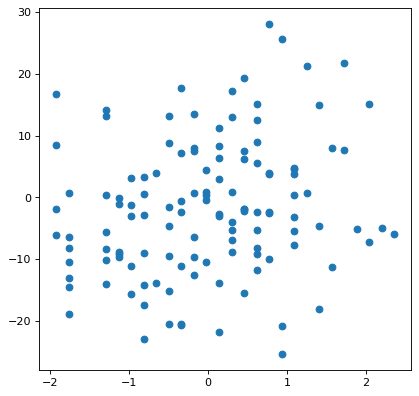

In [52]:
diff = test_pred_mean[:,0]*age_std - test_label[:,0]*age_std
_, _, _, label_ = train_test_split(data_aal,data_label, train_size = 0.8,shuffle=False)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(label_[:,2],diff)
np.corrcoef(label_[:,2],diff)